# Flow modelling – Altering flows

In [1]:
import graph_tool as gt
import graph_tool.draw
import graph_tool.search
import numpy as np
import datetime
import cairo

In [2]:
print("Last run:", datetime.datetime.now().date().isoformat())

Last run: 2018-12-03


## Test data

Let's create an test graph that models cucumber production, packaging and consumption.

In [3]:
G = gt.Graph(directed=True)
G.load("cucumba.gt")

## Graph validation

The following need to be true for a valid graph:

+ vertices have unique names/id

## Plotting functions

In [4]:
def plot_sol_mass(g, colors, mass):
    mass_text = g.new_edge_property("string", vals=[round(i,2) for i in mass])
    gt.draw.graph_draw(g, vertex_size=20, vertex_text=g.vp.id,
                       vprops={"text_position":1, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                       eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "color":colors},
                       edge_text=mass_text,
                       output_size=(700,600), inline=True)

In [5]:
def plot_sol_materials(g, colors, eprop_material):
    gt.draw.graph_draw(g, vertex_size=20, vertex_text=g.vp.id,
                       vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                       eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "color":colors},
                       edge_text=eprop_material,
                       output_size=(700,600), inline=True)

## Flow splitting

In the GDSE, flows have two properties, *mass* [tons] and *material composition* [fraction]. In order to compute stuff in the graph, the flows (edges) need to be split per material, often resulting in paralell edges.

In [6]:
def split_flows(G):
    """Split the flows based on material composition
    
    If a flow is composed of different materials, it is split into individual flows per material 
    with the corresponding mass.
    If the flow is composed of a single material, the composition property is removed and replaced with material.
    
    Returns
    -------
    graph
        The updated graph
    eprop_material
        Edge property (materials), string
    eprop_mass
        Edge property (mass), double
    eprop_mass_text
        Edge property (mass), string, used for plotting the graph
    """
    g = G.copy()
    g.clear_edges()
    del g.edge_properties['flow']
    eprops = G.edge_properties.keys()
    mass_list = []
    material_list = []
    assert 'flow' in eprops, "The graph must have 'flow' edge property"
    e_list = []
    for e in G.edges():
        prop = G.ep.flow[e]
        assert isinstance(prop, dict), "Edge property flow must be a dictionary in edge {}".format(e)
        for material, percent in prop['composition'].items():
            e_list.append(np.array([e.source(), e.target()], dtype=int))
            mass_list.append(float(prop['mass']) * float(percent))
            material_list.append(material)
    e_array = np.vstack(e_list)
    g.add_edge_list(e_array)
    eprop_mass = g.new_edge_property("float", vals=mass_list)
    eprop_mass_text = g.new_edge_property("string", vals=[round(i,2) for i in mass_list])
    eprop_material = g.new_edge_property("string", vals=material_list)
    return (g, eprop_material, eprop_mass, eprop_mass_text)

In [7]:
g_split, eprop_material, eprop_mass, eprop_mass_text = split_flows(G)

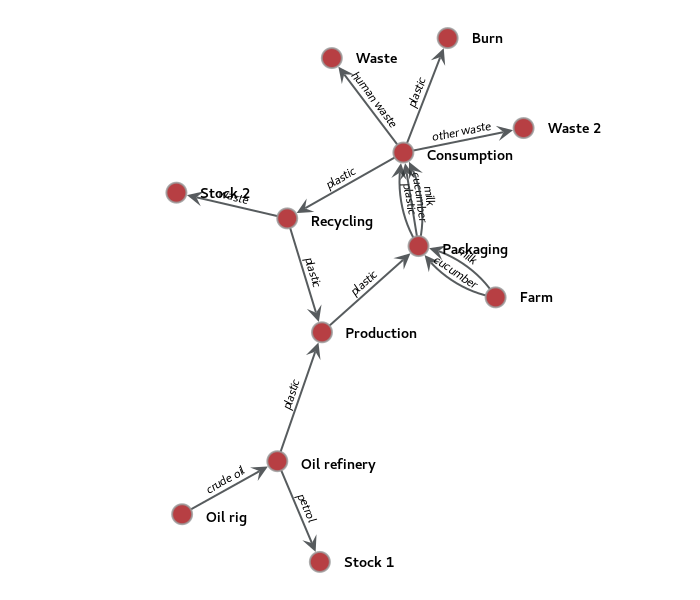

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f9985844c88, at 0x7f9985844358>

In [8]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC},
                   edge_text=eprop_material,
                   output_size=(700,600), inline=True)

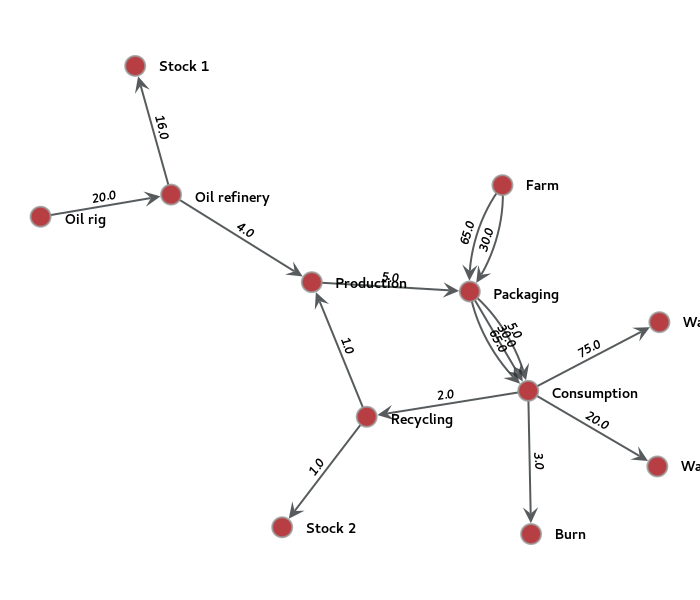

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f9985844c88, at 0x7f99858269e8>

In [9]:
gt.draw.graph_draw(g_split, vertex_size=20, vertex_text=g_split.vp.id,
                   vprops={"text_position":0, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                   eprops={"font_slant":cairo.FONT_SLANT_ITALIC, "text":eprop_mass_text, "font_weight": cairo.FONT_WEIGHT_BOLD},
                   output_size=(700,600), inline=True)

## Computing the change in mass for flows

The goal of this step is to output the change in material mass after applying the solution to the system. In order to compute the change in mass for flows we need:

+ solution,

+ graph.

The **solution** is defined by:

+ the area to which is limited to

+ the **solution parts**, where each part is defined by:

    + *one* material, thus each solution part deals with only a single material
    
    + a <font color='blue'>**solution edge**</font>, which is a single flow on which we apply the solution, eg. reduce the plastic in the Packaging-->Consumption flow
    
    + <font color='green'>**all the flows that are also affected by the solution**</font>, eg. all the connected flows that contain plastic (green arrows)
    
    + the order of computation

This notebook assumes that the area has already been selected for the solution.

### Restricting the graph to the solution part
We need to restrict the graph to the flows that are involved in the *solution part*, otherwise flows might be altered that are not affected by the solution. For example, the solution affects the *Packaging* activity and reduces the amount of plastic packaging on cucumbers by 20%. Thus neither the amount of cucumbers nor the amount of milk should be changed.

Both the milk and cucumber *packaged product* consists of 5% plastic.

Thus the provided <font color='green'>solution modfies the *green*</font> edges and <font color='red'>does not modify the *red* edges</font>. The user is supposed to manually select the flows (green and blue edges) that are affected by the solution.

In [10]:
def define_mask(g, eprop_material, materials):
    """Create an edge mask for the edges that define the solution
    
    g - graph
    eprop_material - edge property map of the materials
    materials - list of strings, if an edge has a material in this list, the edge is included
    """
    cols = []
    mask = g.new_edge_property("bool")
    for i,e in enumerate(g.edges()):
        if eprop_material[e] in materials:
            mask[e] = True
            cols.append("green")
        else:
            mask[e] = False
            cols.append("red")
    
    return (mask, g.new_edge_property("string", vals=cols))

In [11]:
edge_mask_1, ecolors_1 = define_mask(g_split, eprop_material, ['plastic', 'crude oil'])

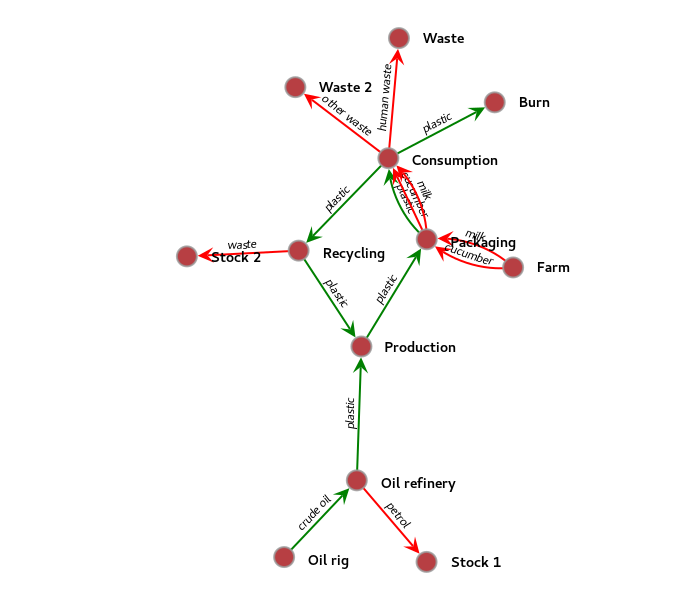

In [12]:
plot_sol_materials(g_split, ecolors_1, eprop_material)

### Traversing the graph

The graph is traversed with the Breadth First Search (BFS) algorithm. This ensures that at each vertex, the immediate neighbours are visited first, before progressing further in the graph. This is important because at each vertex we need to account for all the inflows and outflows.

The starting point is the target vertex of the <font color='blue'>**solution edge**</font>. 

We assume that demand dictates supply. Therefore by default the graph is traversed upstream first, then downstream from the <font color='blue'>**solution edge**</font> in order to visit all edges of the *solution part*. 

### Computing the changes on flows

For each *solution part* and for each edge, we compute the *change in mass* that is caused by the solution. The *change* is a signed floating point number. Thus for example if the solution reduces the plastic by 0.3 tons, then $change=-0.3$.

At each vertex, the change is computed on the inflows. The change computation is a local operation, it does not take into account the previously computed changes on the previous edges. Thus the change(s) do no propagate through the graph. This makes it possible to identify incorrecly defined (or incomplete) solutions, as in the figure below.

At a vertex *V*, we compute *change* for each inflow *E* as:

    If the source of E, sE, has multiple outflows (eg. Consumption), then
    
        change = ( E / sum(outflows of sE) ) * solution
    
    else
    
        change = ( E / sum(inflows of V) ) * solution

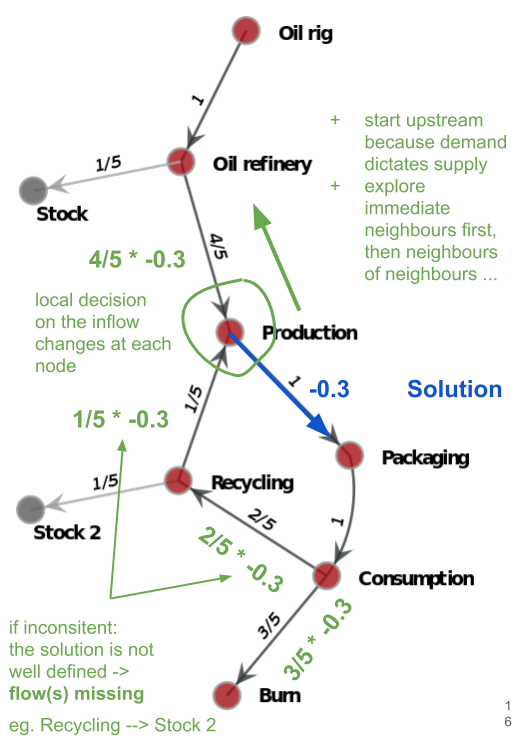

In [13]:
class NodeVisitor(gt.search.BFSVisitor):

    def __init__(self, name, solution, mass, visited, change):
        self.id = name
        self.solution = solution
        self.mass = mass
        self.visited = visited
        self.change = change

    def discover_vertex(self, u):
        """This is invoked when a vertex is encountered for the first time."""
        pass

    def examine_vertex(self, u):
        """Compute the mass change on each inflow for the vertex
        
        This function is invoked on a vertex as it is popped from the queue.

        Returns
        -------
        dict
            {edge : change}
        """
        changes = {}
        if u.in_degree() > 0:
            all_in = list(u.in_edges())
            for i,e in enumerate(all_in):
                if not self.visited[e]:
                    e_src = e.source()
                    e_src_out = [e for e in e_src.out_edges()]
                    if len(e_src_out) > 1:
                        # For the case when an inflow edge shares the source vertex
                        self.change[e] = ( self.mass[e] / sum([self.mass[out_f] for out_f in e_src_out]) ) * self.solution
                    else:
                        self.change[e] = ( self.mass[e] / sum([self.mass[in_f] for in_f in all_in]) ) * self.solution
                    print(self.id[e.source()], '-->', self.id[e.target()], self.change[e])
                    self.visited[e] = True
        else:
            print("source node,", u.vp.id)
        
def traverse_graph(g, edge, include, solution, mass, upstream=True):
    """Traverse the graph in a breadth-first-search manner
    
    Parameters
    ----------
    g : the graph to explore
    edge : the starting edge, normally this is the *solution edge*
    visited : edge propery map (bool) to indicate which edge have been visited
    include : edge propery map (bool) to indicate the edges that are part of the solution definition
    upstream : The direction of traversal. When upstream is True, the graph is explored upstream first, otherwise downstream first.  
    
    Returns
    -------
    None
    """
    # Property map for keeping track of the visited edge. Once an edge has been visited
    # it won't be processed anymore.
    r = (False for x in g.get_edges())
    visited = g.new_edge_property("bool", vals=r)
    change = g.new_edge_property("float")
    #g.edge_properties["change"] = change
    # By default we go upstream first, because 'demand dictates supply'
    if upstream:
        g.set_reversed(True)
    else:
        g.set_reversed(False)
    node = edge.target()
    # We are only interested in the edges that define the solution
    g.set_edge_filter(include)
    print("\nTraversing in 1. direction")
    gt.search.bfs_search(g, node, NodeVisitor(g.vp["id"], solution, mass, visited, change))
    if g.is_reversed():
        g.set_reversed(False)
    else:
        g.set_reversed(True)
    print("\nTraversing in 2. direction")
    gt.search.bfs_search(g, node, NodeVisitor(g.vp["id"], solution, mass, visited, change))
    del visited
    g.set_reversed(False)
    g.clear_filters()
    return change

## Solution 1 – plastic reduction

**Reduce the amount of plastic between Packaging and Consumption by 20% in the part of the cucumber packaging**

There are 30t of cucumbers (net), plus 5% over it in plastic, thus 1,5t of plastic, on the Packaging --> Consumption flow. The solution reduces the 1,5t by 20%, thus there is a change of **-0.3** on the *solution edge*.

Note that **solution** also refers to the signed amount of change in mass on the *solution edge*.

In [14]:
pe = g_split.edge(g_split.vertex(1), g_split.vertex(6), all_edges=True) # the 3 edges between Packaging and Cosumption
sol_e = [e for e in pe if eprop_material[e] == 'plastic'][0] # the specific edge (blue)

In [15]:
# Now we 'implement' the solution.
# The plastic flow contains the combined mass from cucumber and milk packaging, which is 5.0t. From the 5.0t, 1,5t was
# used for cucumbers as explained above. Now, the solution reduces the packaging of cucumbers by 0.3t
solution = -0.3
print("Current combined plastic mass after Packaging:", eprop_mass[sol_e])
print("Solution:", solution)
print("Plastic mass after implementing the solution:", eprop_mass[sol_e] + solution)

Current combined plastic mass after Packaging: 5.0
Solution: -0.3
Plastic mass after implementing the solution: 4.7


In [16]:
edge_mask_1, ecolors_1 = define_mask(g_split, eprop_material, ['plastic', 'crude oil'])
ecolors_1[sol_e] = "blue"

The <font color='blue'>**solution edge**</font> is marked with blue.

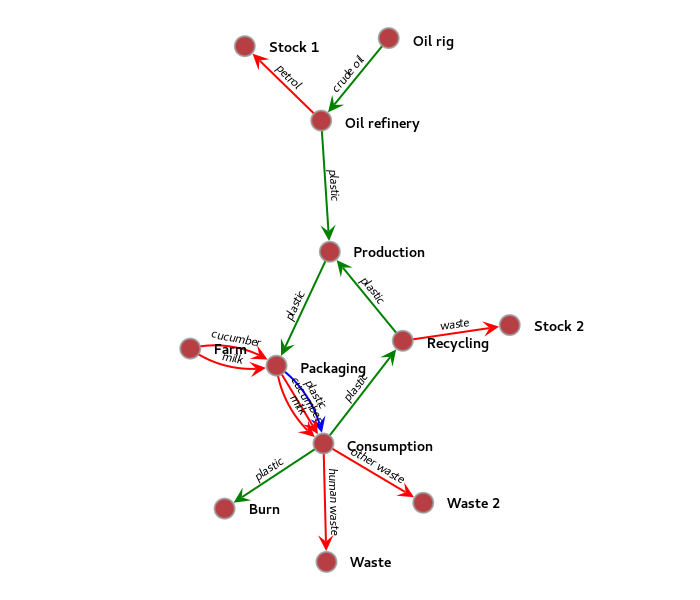

In [17]:
plot_sol_materials(g_split, ecolors_1, eprop_material)

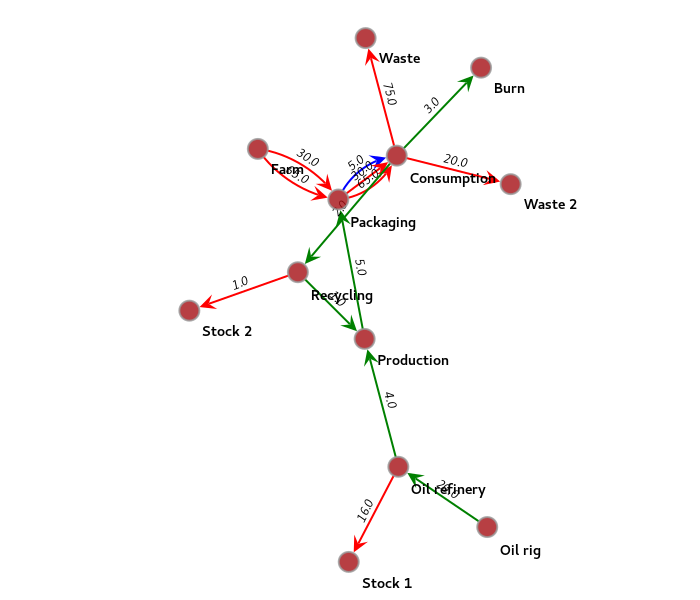

In [18]:
plot_sol_mass(g_split, ecolors_1, eprop_mass)

The we compute the change for each flow.

In [19]:
print("Printing function:")
changes = traverse_graph(g_split, sol_e, edge_mask_1, solution, eprop_mass, upstream=True)

print("\nPrinting output:")
for i,e in enumerate(g_split.edges()):
    if changes[e] != 0.0:
        print(g_split.vp.id[e.source()], '-->', g_split.vp.id[e.target()], changes[e])

Printing function:

Traversing in 1. direction
Burn --> Consumption -0.18
Recycling --> Consumption -0.12
Consumption --> Packaging -0.3
Packaging --> Production -0.3
Production --> Oil refinery -0.24
Production --> Recycling -0.06
Oil refinery --> Oil rig -0.3

Traversing in 2. direction

Printing output:
Packaging --> Consumption -0.3
Oil rig --> Oil refinery -0.3
Oil refinery --> Production -0.24
Production --> Packaging -0.3
Consumption --> Burn -0.18
Consumption --> Recycling -0.12
Recycling --> Production -0.06


## Solution 2 – milk reduction

**Reduce milk production by 40%**

The current milk production is $0.6842*95=65t$ , after implementing the solution it will be reduced by 26t.

Milk is also packaged in plastic, which is *5.4%* ( 3.5/65=0.054 ) over the net mass of the milk. Reducing the milk also reduces the plastic, thus at the end we'll end up with $(65t * 0.6) * 0.054 = 2.106t$ of plastic packaging for the milk.

In [20]:
pe = g_split.edge(g_split.vertex(0), g_split.vertex(1), all_edges=True) # the 2 edges between Farm and Packaging
sol_e_2 = [e for e in pe if eprop_material[e] == 'milk'][0] # the specific edge (blue)
solution_2 = -26.0

print("Current milk mass after Farm:", round(eprop_mass[sol_e_2],2))
print("Solution:", solution_2)
print("Milk mass after implementing the solution:", round(eprop_mass[sol_e_2] + solution_2,2))

Current milk mass after Farm: 65.0
Solution: -26.0
Milk mass after implementing the solution: 39.0


The flows affected by the solution are manually selected by the user.

In [21]:
edge_mask_2, ecolors_2 = define_mask(g_split, eprop_material, ['milk', 'human waste', 'other waste'])
ecolors_2[sol_e_2] = "blue"

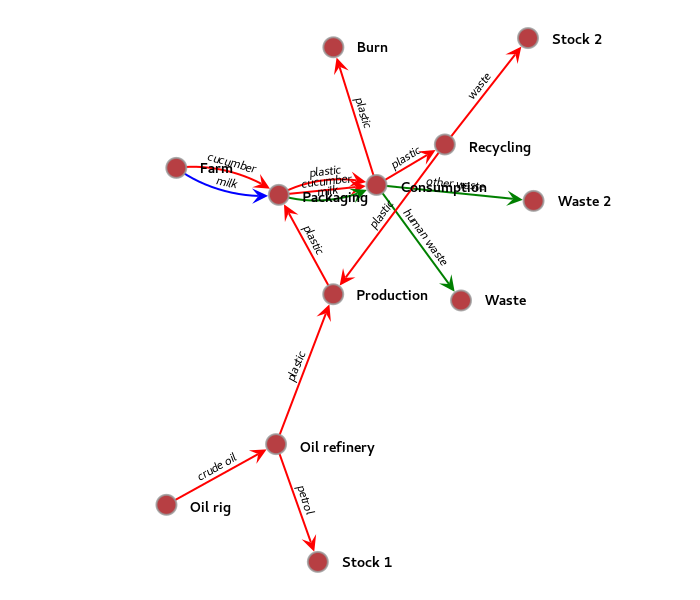

In [22]:
plot_sol_materials(g_split, ecolors_2, eprop_material)

The flow between *Consumption* and *Waste* has a different material (human waste, other waste) than milk. Because this flow (human waste, other waste) doesn't have a composition, we need to calcuate the ratio of milk in it.

In [23]:
print("Printing function:")
changes = traverse_graph(g_split, sol_e_2, edge_mask_2, solution_2, eprop_mass, upstream=True)

print("\nPrinting output:")
for i,e in enumerate(g_split.edges()):
    if changes[e] != 0.0:
        print(g_split.vp.id[e.source()], '-->', g_split.vp.id[e.target()], changes[e])

Printing function:

Traversing in 1. direction
Consumption --> Packaging -26.0
Packaging --> Farm -26.0

Traversing in 2. direction
Consumption --> Waste -20.526315789473685
Consumption --> Waste 2 -5.473684210526315

Printing output:
Farm --> Packaging -26.0
Packaging --> Consumption -26.0
Consumption --> Waste -20.526315789473685
Consumption --> Waste 2 -5.473684210526315


### Compute for the plastic part

Let's compute our expectation for the plastic reduction.

In [24]:
g_split.clear_filters() # remove the edge and vertex masks
pe = g_split.edge(g_split.vertex(1), g_split.vertex(6), all_edges=True) # the 3 edges between Packaging and Cosumption
sol_e_3 = [e for e in pe if eprop_material[e] == 'plastic'][0] # the specific edge (blue)
solution_3 = -0.6017 #Solution-2-–-milk-reduction

print("Current combined plastic mass after Packaging:", eprop_mass[sol_e_3])
print("Solution reduces the plastic mass by:", solution_3, "on the solution edge")
print("Plastic mass of the solution edge after implementing the solution:", round(eprop_mass[sol_e_3] + solution_3, 2))

Current combined plastic mass after Packaging: 5.0
Solution reduces the plastic mass by: -0.6017 on the solution edge
Plastic mass of the solution edge after implementing the solution: 4.4


In [25]:
edge_mask_3, ecolors_3 = define_mask(g_split, eprop_material, ['plastic', 'crude oil'])
ecolors_3[sol_e_3] = "blue"

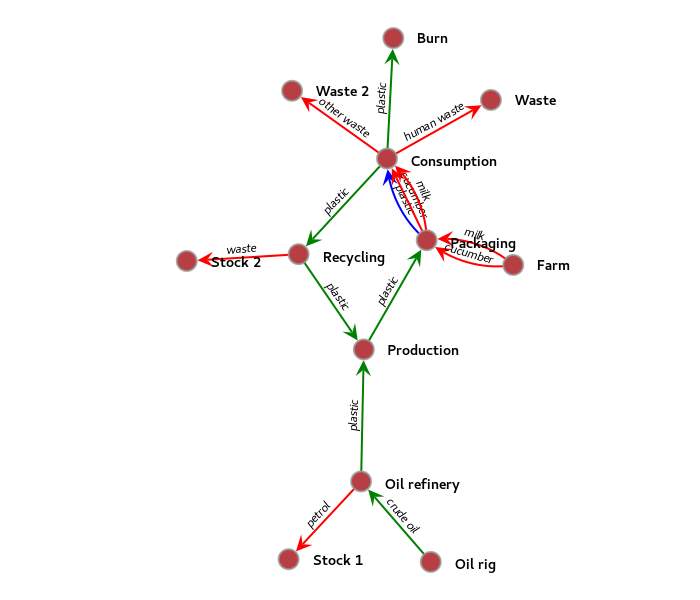

In [26]:
plot_sol_materials(g_split, ecolors_3, eprop_material)

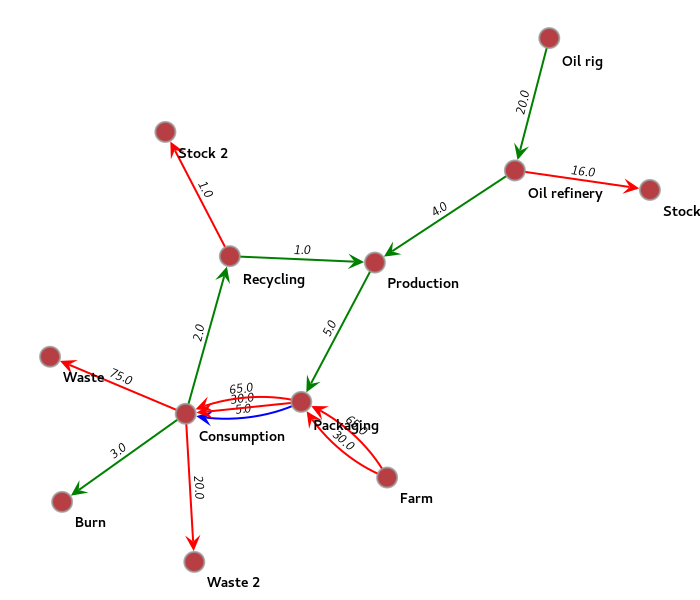

In [27]:
plot_sol_mass(g_split, ecolors_3, eprop_mass)

In [28]:
print("Printing function:")
changes = traverse_graph(g_split, sol_e_3, edge_mask_3, solution_3, eprop_mass, upstream=True)

print("\nPrinting output:")
for i,e in enumerate(g_split.edges()):
    if changes[e] != 0.0:
        print(g_split.vp.id[e.source()], '-->', g_split.vp.id[e.target()], changes[e])

Printing function:

Traversing in 1. direction
Burn --> Consumption -0.36102
Recycling --> Consumption -0.24068
Consumption --> Packaging -0.6017
Packaging --> Production -0.6017
Production --> Oil refinery -0.48136
Production --> Recycling -0.12034
Oil refinery --> Oil rig -0.6017

Traversing in 2. direction

Printing output:
Packaging --> Consumption -0.6017
Oil rig --> Oil refinery -0.6017
Oil refinery --> Production -0.48136
Production --> Packaging -0.6017
Consumption --> Burn -0.36102
Consumption --> Recycling -0.24068
Recycling --> Production -0.12034
